# Barlow Twins Adaptation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.append('/content/drive/MyDrive/Colab/170')


In [ ]:
from model import BarlowTwinsAdaptation
from transform import TransformFirst, TransformSecond, Transform
from metrics import Metrics

import os
import shutil
import random
import math
from PIL import Image, ImageOps, ImageFilter

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torchvision
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
from tensorflow.keras.utils import load_img, img_to_array
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

import kagglehub
import matplotlib.pyplot as plt

from warnings import filterwarnings
from IPython.display import clear_output
from tqdm import tqdm

filterwarnings('ignore')


In [ ]:
ROOT_DIR = "drive/MyDrive/Colab/170"

def save_to_drive(filepath, folder=''):
    if folder == '':
        !cp -r $filepath $ROOT_DIR/
    else:
        !cp -r $filepath $ROOT_DIR/$folder/

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [ ]:
class ImageDataset(Dataset):
    '''
    Simple torch dataset class for images
    '''
    def __init__(self, image_array, transform=None):
        self.image_array = image_array
        self.transform = transform

    def __len__(self):
        return len(self.image_array)

    def __getitem__(self, idx):
        if self.transform:
            return self.transform(self.image_array[idx])
        return self.image_array[idx]

class RandomPairImageDataset(Dataset):
    '''
    Dataset which returns a random pair of images
    '''
    def __init__(self, image_array, transform_first=None, transform_second=None, same_prob=0.5):
        '''
        transform_first: transform for first image
        transform_second: transform for second image
        same_prob: probability of returning first_image == second_image
                   before transformations
        '''
        self.image_array = image_array
        self.transform_first = transform_first
        self.transform_second = transform_second
        self.same_prob = same_prob

    def __len__(self):
        return len(self.image_array)

    def __getitem__(self, idx):
        first_img = self.image_array[idx]
        same_img = 0
        if random.random() < self.same_prob:
            second_img = first_img
            same_img = 1
        else:
            second_img = random.choice(self.image_array)
        if self.transform_first:
            first_img = self.transform_first(first_img)
        if self.transform_second:
            second_img = self.transform_second(second_img)
        return (torch.cat((first_img.unsqueeze(0), second_img.unsqueeze(0))), torch.tensor(same_img).float())

def load_images(folder_path, count):
    '''
    Loads images from the folder
    and store them as a list of PIL images
    '''
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    images = []
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(file_path).convert('RGB')
            img_tensor = transform(img)
            images.append(img_tensor)
        if len(images) == count:
            break
    return images

def load_dataset(folder_path, shuffle=True):
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])
    images = []
    folder_path = ROOT_DIR + "/" + folder_path
    for file_name in os.listdir(folder_path):
        file_path = os.path.join(folder_path, file_name)
        if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
            img = Image.open(file_path).convert('RGB')
            img_tensor = transform(img)
            images.append(img_tensor)
    if shuffle:
        random.shuffle(images)
    return images


## Experiment: Dataset of different biological scans

Images: 700


In [ ]:
train_share = 80

images = load_dataset("dataset", shuffle=True)
print(len(images))

train_size = int(len(images) * train_share / 100)

for i in range(len(images)):
    images[i] = to_pil_image(images[i])

train = images[:train_size]
validation = images[train_size:]

proj_train_dataset = ImageDataset(train,
                       transform=Transform())
proj_validation_dataset = ImageDataset(validation,
                       transform=Transform())

sim_train_dataset = RandomPairImageDataset(train,
                       transform_first=TransformFirst(),
                       transform_second=TransformSecond(),
                       same_prob=0.4)
sim_validation_dataset = RandomPairImageDataset(validation,
                       transform_first=TransformFirst(),
                       transform_second=TransformSecond(),
                       same_prob=0.4)

proj_train_dataloader = DataLoader(proj_train_dataset, batch_size=16, shuffle=True)
proj_validation_dataloader = DataLoader(proj_validation_dataset, batch_size=16, shuffle=True)

sim_train_dataloader = DataLoader(sim_train_dataset, batch_size=16, shuffle=True)
sim_validation_dataloader = DataLoader(sim_validation_dataset, batch_size=16, shuffle=True)


700


In [ ]:
model_projector_layers = [2048, 4096, 4096, 4096]

## Variant 1: Training projector and similarity net separately

### Training projector (200 epochs)


In [ ]:
resnet_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model_1 = BarlowTwinsAdaptation(resnet_model, model_projector_layers, lambd=4e-3)

In [ ]:
optimizer = torch.optim.AdamW(model_1.parameters())

_, _ = model_1.train_projector(
    proj_train_dataloader,
    proj_validation_dataloader,
    optimizer,
    start_lr=3e-4,
    end_lr=1e-4,
    epochs=50
)


### Training similarity net (100 epochs)


In [ ]:
optimizer = torch.optim.AdamW(model_1.parameters())

_, _, train_acc, validation_acc = model_1.train_similarity_net(
    sim_train_dataloader,
    sim_validation_dataloader,
    optimizer,
    start_lr=1e-3,
    end_lr=1e-4,
    epochs=100
)


## Variant 2: Training projector and similarity net together with combined loss

$\mathcal{L}(x_1, x_2) =
\mathcal{L}_{BCE}(x_1, x_2) + \lambda \cdot \mathcal{L}_{BT}(x_1, x_2)$

### 200 epochs


In [ ]:
resnet_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model_2 = BarlowTwinsAdaptation(resnet_model, model_projector_layers, lambd=4e-3)

Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


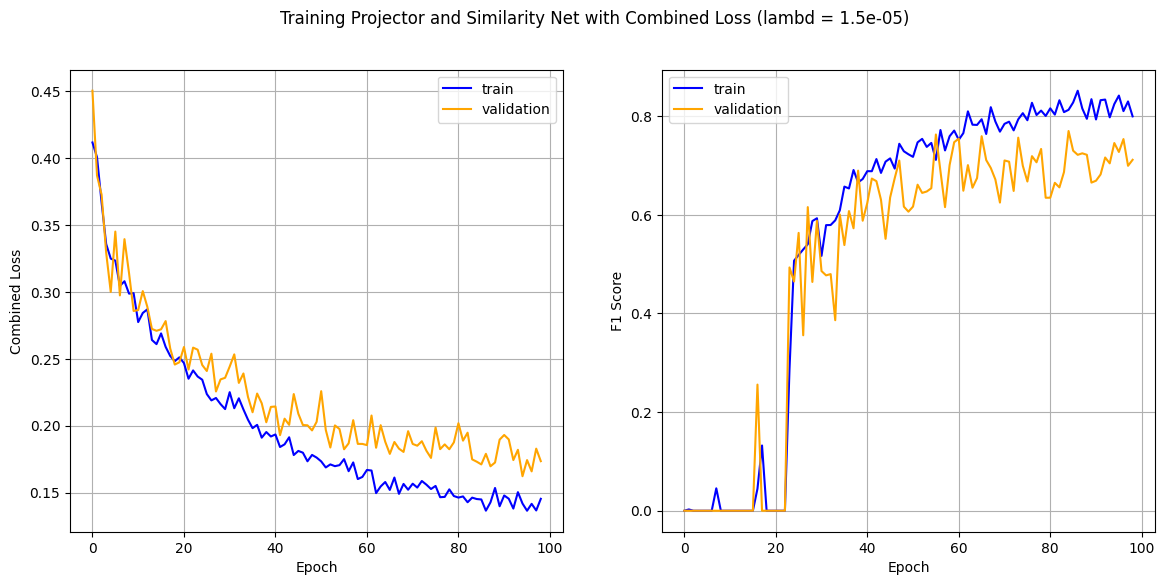

100%|██████████| 100/100 [31:33<00:00, 18.93s/it]


In [ ]:
optimizer = torch.optim.AdamW(model_2.parameters())

_, _ = model_2.train_projector_and_similarity_net_with_combined_loss(
    proj_train_dataloader,
    proj_validation_dataloader,
    optimizer,
    start_lr=3e-3,
    end_lr=5e-4,
    lambd=2e-5,
    epochs=100
)


## Saving model weights and learning info

In [ ]:
def save_model_and_learning_stat(model, dataname, folder):
    '''
    Saving model weights and learning statistics
    '''
    torch.save(model.state_dict(), dataname + ".pth")
    folder = "models/" + folder
    save_to_drive(dataname + ".pth", folder=folder)


In [ ]:
# save_model_and_learning_stat(model_1, "BTA_proj200ep-sim100ep", folder='BTA')
# save_model_and_learning_stat(model_2, "BTA-combined_100ep", folder='BTA-combined')

## Calculating accuracy metrics

In [ ]:
resnet_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
model = BarlowTwinsAdaptation(resnet_model, model_projector_layers, lambd=4e-3)
model.load_state_dict(torch.load(ROOT_DIR + "/models/BTA-combined-lambdas/BTA-combined_100ep_lambda-2e-5.pth",
                                        map_location=torch.device("cpu")))
model.to(device)
print("Done")

Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


Done


In [ ]:
validation_dataset = RandomPairImageDataset(validation,
                       transform_first=TransformFirst(),
                       transform_second=TransformSecond(),
                       same_prob=0.4)

validation_dataloader = DataLoader(validation_dataset, batch_size=16, shuffle=True)


In [ ]:
def calculate_metrics(model, dataloader):

    N = 10

    avg_accuracy = 0
    avg_f1_score = 0
    avg_precision = 0
    avg_recall = 0
    avg_roc_auc = 0

    for _ in tqdm(range(N)):

        all_outputs = []
        all_targets = []
        for inputs, targets in dataloader:
            inputs = inputs.to(device)
            targets = targets.to(device)
            x1 = inputs[:, 0, :, :, :]
            x2 = inputs[:, 1, :, :, :]

            outputs = model(x1, x2)

            all_outputs.append(outputs.detach().cpu())
            all_targets.append(targets.detach().cpu())

        all_outputs = torch.cat(all_outputs)
        all_targets = torch.cat(all_targets)

        accuracy = Metrics.accuracy(all_outputs, all_targets)
        f1_score = Metrics.f1_score(all_outputs, all_targets)
        precision = Metrics.precision(all_outputs, all_targets)
        recall = Metrics.recall(all_outputs, all_targets)

        fpr, tpr, thresholds = roc_curve(all_targets, all_outputs)
        roc_auc = auc(fpr, tpr)

        avg_accuracy += accuracy
        avg_f1_score += f1_score
        avg_precision += precision
        avg_recall += recall
        avg_roc_auc += roc_auc

    avg_accuracy /= N
    avg_f1_score /= N
    avg_precision /= N
    avg_recall /= N
    avg_roc_auc /= N

    print()
    print(f"Accuracy: {avg_accuracy:.4f}")
    print(f"F1-score: {avg_f1_score:.4f}")
    print(f"Precision: {avg_precision:.4f}")
    print(f"Recall: {avg_recall:.4f}")

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='red', lw=2, label=f'AUC = {avg_roc_auc:.4f}')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('FP Rate', fontsize=14)
    plt.ylabel('TP Rate', fontsize=14)
    plt.tick_params(labelsize=12)

    plt.legend(loc="lower right", fontsize=14)
    plt.show()


In [ ]:
calculate_metrics(model_2, validation_dataloader)


## Comparing with original Barlow Twins (pretrained ResNet50 encoder and projector)

In [ ]:
def prepare_checkpoint(checkpoint_path, save_path=None):
    checkpoint = torch.load(ROOT_DIR + "/" + checkpoint_path, map_location=device)
    if isinstance(checkpoint, dict) and "state_dict" in checkpoint:
        state_dict = checkpoint["state_dict"]
    else:
        state_dict = checkpoint

    prefixes = ["module.projector", "module.bn"]

    filtered_state_dict = {
        k[len("module."):]: v for k, v in state_dict["model"].items()
        if any(k.startswith(prefix) for prefix in prefixes)
    }

    if save_path:
        torch.save(filtered_state_dict, ROOT_DIR + "/" + save_path)
    return filtered_state_dict


In [ ]:
'''
filtered_state_dict = prepare_checkpoint(
    checkpoint_path="models/BT_checkpoint.pth",
    save_path="models/BT_filtered_checkpoint.pth"
)
'''

filtered_state_dict = torch.load(ROOT_DIR + "/models/BT_filtered_checkpoint.pth", map_location=torch.device("cpu"))

In [ ]:
resnet_model = torch.hub.load('facebookresearch/barlowtwins:main', 'resnet50')
original = BarlowTwinsAdaptation(resnet_model, [2048, 8192, 8192, 8192], lambd=5e-3)

target_state_dict = original.state_dict()

for name, param in filtered_state_dict.items():
    if name in target_state_dict and param.size() == target_state_dict[name].size():
        target_state_dict[name] = param
    else:
        print("Weights", name, "mismatched")

original.load_state_dict(target_state_dict, strict=False)


Using cache found in /root/.cache/torch/hub/facebookresearch_barlowtwins_main


<All keys matched successfully>

## Training similarity net (100 epochs)

In [ ]:
optimizer = torch.optim.AdamW(original.parameters())

_, _, train_acc, validation_acc = original.train_similarity_net(
    sim_train_dataloader,
    sim_validation_dataloader,
    optimizer,
    start_lr=3e-3,
    end_lr=5e-4,
    epochs=100
)


## Metrics

In [ ]:
calculate_metrics(original, validation_dataloader)